Using device: cpu
Example images:


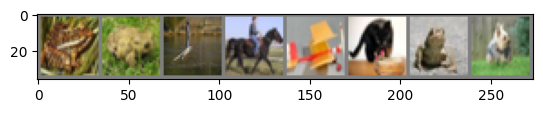

Labels: frog  frog  bird  horse plane cat   frog  dog  


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Set device to GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# 1. Load and normalize CIFAR-10
# The transform pipeline first converts images to PyTorch tensors,
# then normalizes their pixel values to have a mean of 0.5 and a std of 0.5.
# This helps the network train more effectively.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# 2. Visualize some training images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

print('Example images:')
imshow(torchvision.utils.make_grid(images[:8]))
print('Labels:', ' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

In [2]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_pipeline = nn.Sequential(
            # Input: 3x32x32
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # -> 16x16x16
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
            # -> 32x8x8
        )
        self.fc_pipeline = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.conv_pipeline(x)
        x = self.fc_pipeline(x)
        return x

model = SimpleCNN().to(device)
print(model)

SimpleCNN(
  (conv_pipeline): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_pipeline): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [3]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [4]:
from tqdm import tqdm

num_epochs = 10
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Use tqdm for a nice progress bar
    progress_bar = tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs}')

    for i, data in enumerate(progress_bar):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        
        # Update progress bar
        progress_bar.set_postfix({'loss': running_loss / (i + 1), 'accuracy': 100 * correct_predictions / total_predictions})

    epoch_train_loss = running_loss / len(trainloader)
    epoch_train_acc = correct_predictions / total_predictions
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_predictions_val = 0
    total_predictions_val = 0

    with torch.no_grad():  # No need to track gradients for validation
        for data in testloader:  # Assuming `testloader` is your validation set
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_predictions_val += labels.size(0)
            correct_predictions_val += (predicted == labels).sum().item()

    epoch_val_loss = val_loss / len(testloader)
    epoch_val_acc = correct_predictions_val / total_predictions_val
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc*100:.2f}%, "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc*100:.2f}%")

print('\nFinished Training')

Epoch 1/10: 100%|██████████| 782/782 [00:29<00:00, 26.86it/s, loss=1.52, accuracy=45]  


Epoch 1/10 - Train Loss: 1.5166, Train Acc: 45.01%, Val Loss: 1.2852, Val Acc: 53.08%


Epoch 2/10: 100%|██████████| 782/782 [00:31<00:00, 25.21it/s, loss=1.15, accuracy=58.8]


Epoch 2/10 - Train Loss: 1.1510, Train Acc: 58.81%, Val Loss: 1.0759, Val Acc: 61.63%


Epoch 3/10: 100%|██████████| 782/782 [00:27<00:00, 28.12it/s, loss=0.963, accuracy=65.9]


Epoch 3/10 - Train Loss: 0.9630, Train Acc: 65.86%, Val Loss: 0.9761, Val Acc: 65.14%


Epoch 4/10: 100%|██████████| 782/782 [00:27<00:00, 28.00it/s, loss=0.838, accuracy=70.4]


Epoch 4/10 - Train Loss: 0.8384, Train Acc: 70.37%, Val Loss: 0.8914, Val Acc: 68.61%


Epoch 5/10: 100%|██████████| 782/782 [00:28<00:00, 27.90it/s, loss=0.738, accuracy=74.1]


Epoch 5/10 - Train Loss: 0.7377, Train Acc: 74.11%, Val Loss: 0.9175, Val Acc: 68.39%


Epoch 6/10: 100%|██████████| 782/782 [00:27<00:00, 28.64it/s, loss=0.643, accuracy=77.3]


Epoch 6/10 - Train Loss: 0.6433, Train Acc: 77.33%, Val Loss: 0.8997, Val Acc: 70.09%


Epoch 7/10: 100%|██████████| 782/782 [00:27<00:00, 28.77it/s, loss=0.56, accuracy=80.3] 


Epoch 7/10 - Train Loss: 0.5602, Train Acc: 80.34%, Val Loss: 0.9257, Val Acc: 69.64%


Epoch 8/10: 100%|██████████| 782/782 [00:27<00:00, 28.63it/s, loss=0.475, accuracy=83.4]


Epoch 8/10 - Train Loss: 0.4754, Train Acc: 83.39%, Val Loss: 0.9301, Val Acc: 69.48%


Epoch 9/10: 100%|██████████| 782/782 [00:27<00:00, 28.13it/s, loss=0.399, accuracy=86.3]


Epoch 9/10 - Train Loss: 0.3994, Train Acc: 86.25%, Val Loss: 1.0278, Val Acc: 68.81%


Epoch 10/10: 100%|██████████| 782/782 [00:27<00:00, 28.32it/s, loss=0.334, accuracy=88.4]


Epoch 10/10 - Train Loss: 0.3341, Train Acc: 88.35%, Val Loss: 1.1418, Val Acc: 69.22%

Finished Training


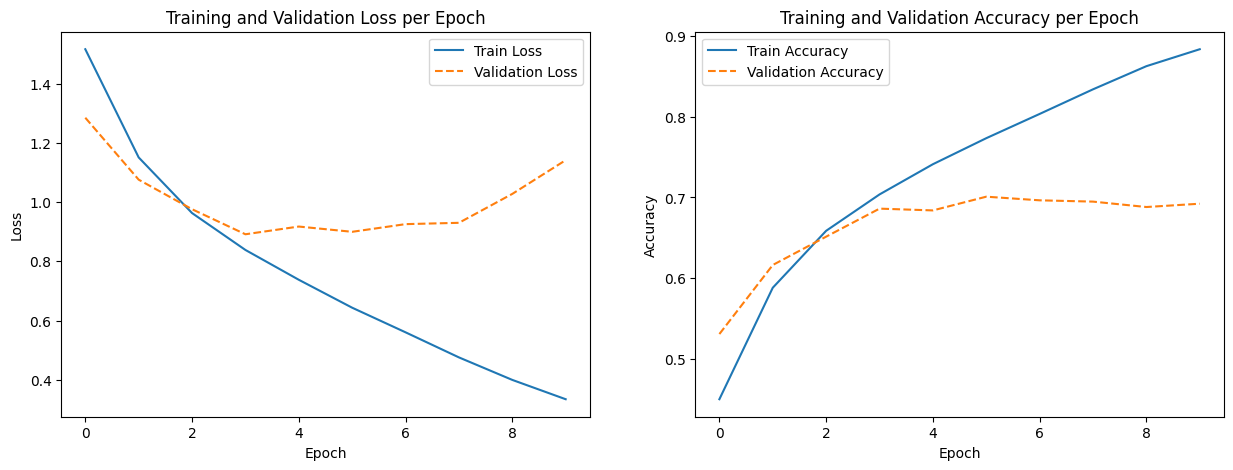

In [5]:
# Plotting the loss and accuracy curves for both training and validation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot training and validation loss
ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['val_loss'], label='Validation Loss', linestyle='--')
ax1.set_title('Training and Validation Loss per Epoch')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot training and validation accuracy
ax2.plot(history['train_acc'], label='Train Accuracy')
ax2.plot(history['val_acc'], label='Validation Accuracy', linestyle='--')
ax2.set_title('Training and Validation Accuracy per Epoch')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

In [10]:
correct = 0
total = 0
model.eval() # Set the model to evaluation mode
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 69 %


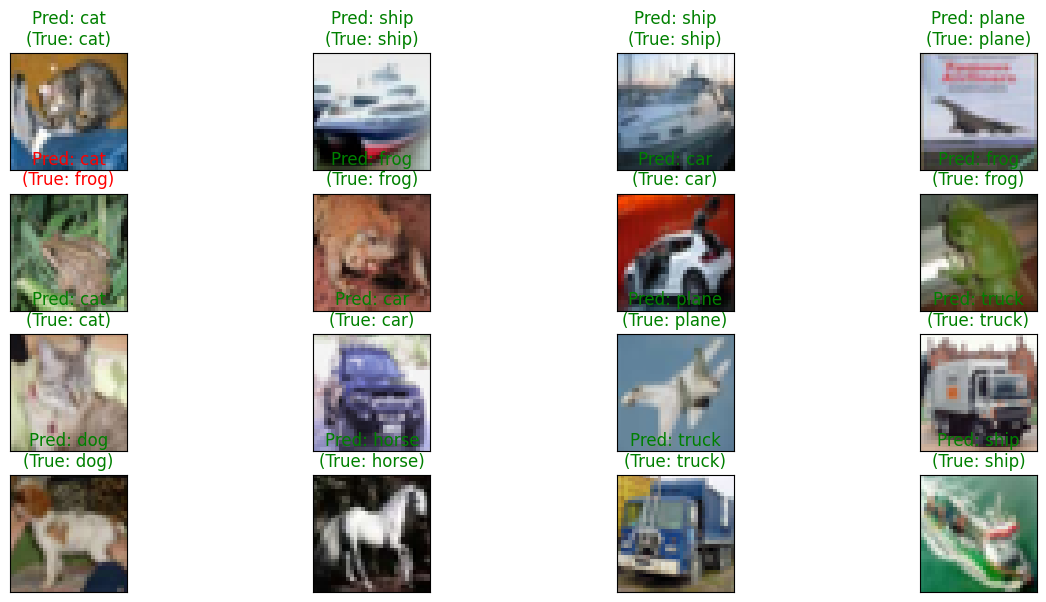

In [11]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images_to_show = images[:16].to(device)
labels_to_show = labels[:16]

outputs = model(images_to_show)
_, predicted = torch.max(outputs, 1)

fig = plt.figure(figsize=(15, 7))
for idx in np.arange(16):
    ax = fig.add_subplot(4, 4, idx+1, xticks=[], yticks=[])
    img = images_to_show[idx].cpu() / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    color = "green" if predicted[idx]==labels_to_show[idx] else "red"
    ax.set_title(f"Pred: {classes[predicted[idx]]}\n(True: {classes[labels_to_show[idx]]})", color=color)

plt.show()

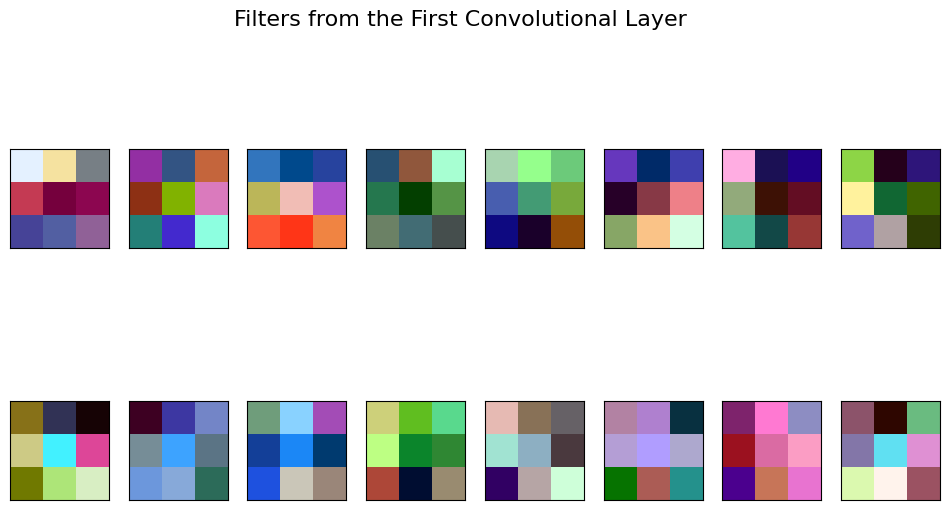

In [12]:
# Get the weights of the first convolutional layer
first_conv_layer = model.conv_pipeline[0]
weights = first_conv_layer.weight.data.cpu()

fig = plt.figure(figsize=(12, 6))
for i in range(weights.shape[0]):
    ax = fig.add_subplot(2, 8, i+1, xticks=[], yticks=[])
    # Normalize the weights to be between 0 and 1 for visualization
    filt = weights[i].numpy()
    filt = (filt - filt.min()) / (filt.max() - filt.min())
    ax.imshow(np.transpose(filt, (1, 2, 0)))
fig.suptitle('Filters from the First Convolutional Layer', fontsize=16, y=1.02)
plt.show()

Feature map activations for an image of a 'frog':


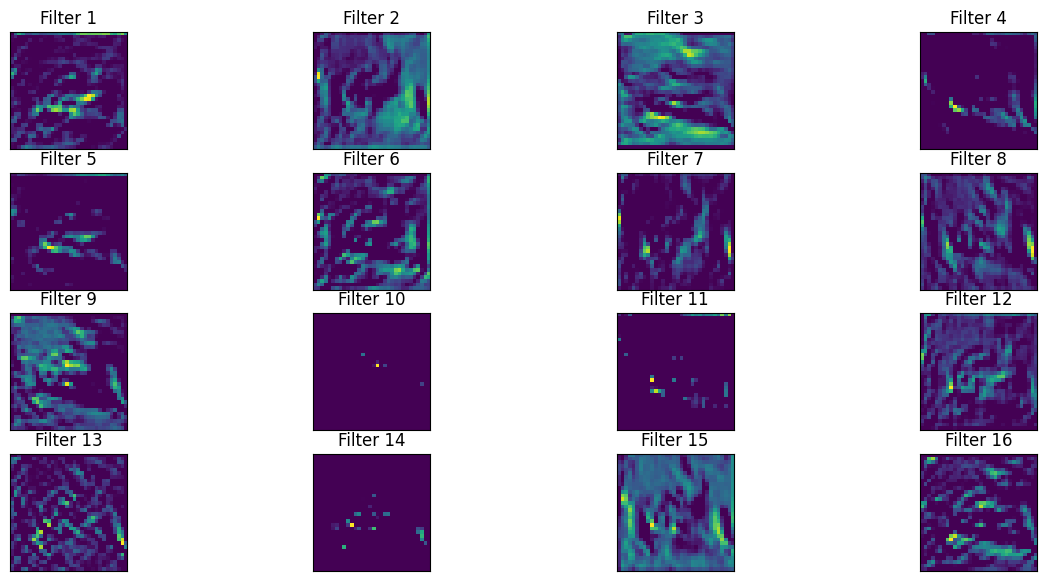

In [13]:
# Take one image
img_to_visualize = testset[5][0].unsqueeze(0).to(device)
label = classes[testset[5][1]]

# Pass it through the first conv layer and activation
with torch.no_grad():
    activations = model.conv_pipeline[1](model.conv_pipeline[0](img_to_visualize))

activations = activations.cpu()

fig = plt.figure(figsize=(15, 7))
for i in range(activations.shape[1]):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    ax.imshow(activations[0, i, :, :], cmap='viridis')
    ax.set_title(f'Filter {i+1}')

print(f"Feature map activations for an image of a '{label}':")
plt.show()